In [1]:
import pygsti
from scipy.linalg import expm
import numpy as np
from pygsti.tools import unitary_to_superop
from pygsti.modelpacks import smq1Q_XYZI
from matplotlib import pyplot as plt
from pygsti.circuits import Circuit
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ
from tqdm import tqdm
from importlib import reload
import kalman_rpe_v2 as _krpe

In [2]:
reload(_krpe)

<module 'kalman_rpe_v2' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_rpe_v2.py'>

In [3]:
from matplotlib import cm

def plot_trajectories(trajectories, uncertainties=None, labels=None, colormap=None, start_idx=0, num_params=3):
    # plot 3 params over time
    fig, ax = plt.subplots(num_params, 1, figsize=(10, 10))
    if uncertainties is None:
        uncertainties = [None]*len(trajectories)
    if labels is None:
        labels = [None]*len(trajectories)
    if colormap is None:
        colormap = cm.get_cmap('viridis', 12)
    for i in range(num_params):
        for idx, (traj, uncert, label) in enumerate(zip(trajectories, uncertainties, labels)):
            if len(traj.shape) == 1:
                traj = np.expand_dims(traj, axis=1)
            if traj.shape[1] > i:
                spacing = np.ceil(len(trajectories[0])/len(traj))
                traj_line = np.repeat(traj[:, i], spacing)
                if num_params == 1:
                    ax.plot(np.arange(start_idx, len(traj_line), 1), traj_line[start_idx:], label=label, color=colormap(idx/len(trajectories)))
                else:
                    ax[i].plot(np.arange(start_idx, len(traj_line), 1), traj_line[start_idx:], label=label, color=colormap(idx/len(trajectories)))
                if uncert is not None:
                    uncert_line = np.repeat(uncert[:, i], spacing)
                    ax[i].fill_between(np.arange(start_idx, len(traj_line), 1), traj_line[start_idx:] - uncert_line[start_idx:], traj_line[start_idx:] + uncert_line[start_idx:], alpha=0.2, color=colormap(idx/len(trajectories)))
        if num_params == 1:
            ax.set_xlabel("Time")
            ax.set_ylabel(f"Parameter {i}")
            ax.legend()
        else:
            ax[i].set_xlabel("Time")
            ax[i].set_ylabel(f"Parameter {i}")
            ax[i].legend()
    plt.show()

In [4]:
def rectify_phase(x):
    """
    Rectify the phase of a state vector to be between -pi and pi
    """
    return (x + np.pi) % (2 * np.pi) - np.pi

In [183]:
def make_x_cos_circ_def(depth):
    return (depth, '0', '0')

def make_x_sin_circ_def(depth):
    return (depth, '0', 'R')

def sample_trig_experiment(xtraj, depths, samples_per_circuit, cos_circ_defs, sin_circ_defs):
    cos_shot_data = { d : np.zeros(2) for d in depths }
    sin_shot_data = { d : np.zeros(2) for d in depths }
    itr = 0
    for idx_s in range(samples_per_circuit):
        for idx_d, d in enumerate(depths):
            if itr + 1 >= len(xtraj):
                break
            shot = _krpe.rpe_observation(xtraj[itr], [cos_circ_defs[idx_d]], 1)
            if shot:
                cos_shot_data[d][1] += 1
            else:
                cos_shot_data[d][0] += 1
            itr += 1
            shot = _krpe.rpe_observation(xtraj[itr], [sin_circ_defs[idx_d]], 1)
            if shot:
                sin_shot_data[d][1] += 1
            else:
                sin_shot_data[d][0] += 1
            itr += 1
    return cos_shot_data, sin_shot_data

def process_rpe_data(cos_shots_at_depth, sin_shots_at_depth, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        experiment.process_cos(d, (int(cos_shots_at_depth[d][1]), int(cos_shots_at_depth[d][0])))
        experiment.process_sin(d, (int(sin_shots_at_depth[d][0]), int(sin_shots_at_depth[d][1])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

def sample_and_make_rpe_estimate(true_x_traj, depths, samples_per_circuit, cos_circ_defs, sin_circ_defs):
    cos_shot_data, sin_shot_data = sample_trig_experiment(true_x_traj, depths, samples_per_circuit, cos_circ_defs, sin_circ_defs)
    angle_estimates, last_good_gen = process_rpe_data(cos_shot_data, sin_shot_data, depths)
    return rectify_phase(angle_estimates)/4, last_good_gen

/tmp/ipykernel_11864/648260123.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


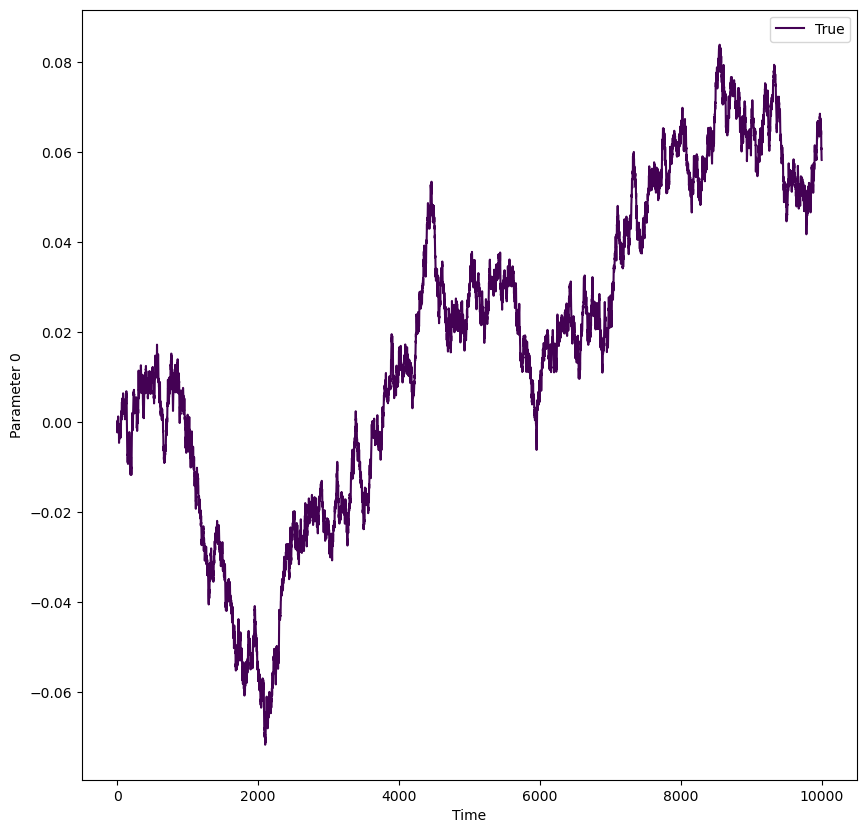

In [194]:
x_inital = np.zeros(4)
q_true = (0.001)**2
num_steps = 10000
xtraj = _krpe.make_xstate_timseries(x_inital, q_true, num_steps)
plot_trajectories([xtraj], labels=["True"], num_params=1)

In [195]:
depths = [2**i for i in range(15)]
samples_per_circuit = 100

cos_circ_defs = [make_x_cos_circ_def(d) for d in depths]
sin_circ_defs = [make_x_sin_circ_def(d) for d in depths]

num_shots_in_window = samples_per_circuit*2
x_traj_windows = [xtraj[i*num_shots_in_window:(i+1)*num_shots_in_window] for i in range(int(len(xtraj)/num_shots_in_window))]

rpe_estimates = []
last_good_gens = []
for x_traj_window in tqdm(x_traj_windows):
    rpe_estimate, last_good_gen = sample_and_make_rpe_estimate(x_traj_window, depths, samples_per_circuit, cos_circ_defs, sin_circ_defs)
    rpe_estimates.append(rpe_estimate)
    last_good_gens.append(last_good_gen)

100%|██████████| 50/50 [00:04<00:00, 11.13it/s]


In [196]:
def plot_rpe_estimate_trajectories(rpe_estimates):
    """
    Plot the RPE estimates over time.

    each vector in the list of rpe estimates is an estimate at each depth
    plot the different depths as different lines
    """
    rpe_estimates = np.array(rpe_estimates.copy())
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for idx, rpe_estimate in enumerate(rpe_estimates.T):
        ax.plot(rpe_estimate, label=f"Depth {depths[idx]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Estimate")
    ax.legend()
    

/tmp/ipykernel_11864/648260123.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


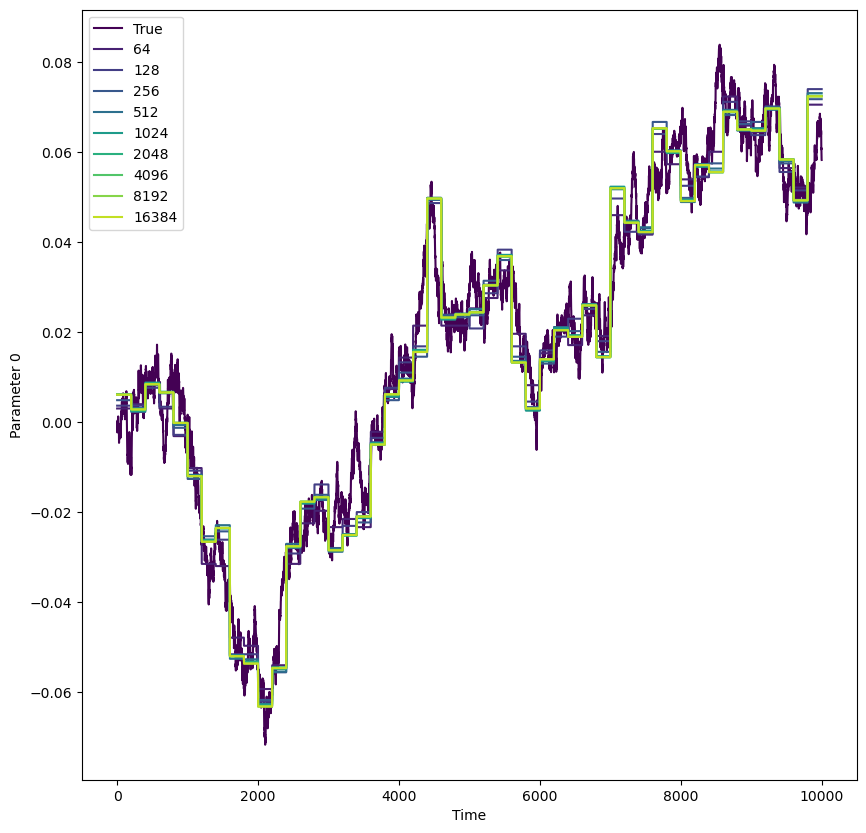

In [197]:
starting_depth_to_plot = 6
plot_trajectories([xtraj, *((np.array(rpe_estimates).T)[starting_depth_to_plot:])], labels=["True", *depths[starting_depth_to_plot:]], num_params=1)

In [198]:
# calculate the covaraince in each depth trajectory
def calculate_variance(rpe_estimates, depths):
    rpe_estimates = np.array(rpe_estimates.copy()).T
    covariances = []
    for idx, depth in enumerate(depths):
        covariances.append(np.var(rpe_estimates[idx]))
    return covariances

In [199]:
min_last_good_gen = np.min(last_good_gens)
print(min_last_good_gen)

2


In [200]:
q_true

1e-06

In [201]:
variances = calculate_variance(rpe_estimates, depths)

In [202]:
q_true

1e-06

In [203]:
expected_shot_noise = np.pi/(num_shots_in_window*depths[-1]**2)
print(expected_shot_noise)

np.array(variances)/(num_shots_in_window) 

5.851672317068639e-11


array([3.47743356e-05, 1.58713351e-05, 7.71866261e-06, 6.18942767e-06,
       6.11666580e-06, 6.18081687e-06, 6.46015559e-06, 6.49150249e-06,
       6.61783077e-06, 6.57862403e-06, 6.55426983e-06, 6.55784036e-06,
       6.55922660e-06, 6.56107496e-06, 6.56065454e-06])

In [143]:
[np.pi/(num_shots_in_window*d**2) for d in depths]

[0.015707963267948967,
 0.003926990816987242,
 0.0009817477042468104,
 0.0002454369260617026,
 6.135923151542565e-05,
 1.5339807878856413e-05,
 3.834951969714103e-06,
 9.587379924285258e-07,
 2.3968449810713145e-07,
 5.992112452678286e-08,
 1.4980281131695716e-08,
 3.745070282923929e-09,
 9.362675707309822e-10,
 2.3406689268274556e-10,
 5.851672317068639e-11]

In [144]:
q_true

1e-08

In [145]:
variances[8]

1.1833911289939114e-05

In [146]:
1/(num_shots_in_window*2**(2*min_last_good_gen))

7.8125e-05

In [147]:
q_true

1e-08

In [20]:
def prob_estimator(p0, pr):
    return np.arctan2(1-2*pr, 1-2*p0)

def trig_prob_derivative_numeric(p0, pr, epsilon=1e-6):
    d_p0 = (prob_estimator(p0 + epsilon, pr) - prob_estimator(p0 - epsilon, pr))/(2*epsilon)
    d_pr = (prob_estimator(p0, pr + epsilon) - prob_estimator(p0, pr - epsilon))/(2*epsilon)
    return np.array([d_p0, d_pr])

phase_estimator

def expected_covar_due_to_shot_noise_at_zero(num_shots, d):
    return 1/(num_shots*d**2)

NameError: name 'phase_estimator' is not defined

In [ ]:
trig_prob_derivative_numeric(0.9, 0.1)

array([1.25, 1.25])

In [ ]:
expected_covar_due_to_shot_noise_at_zero(100)

0.01